# Raport 2: Implementacja Podstawowa
## Detekcja Anomalii - LOF i PCA

**Projekt 7**: Anomalia i uczenie maszynowe  
**Rok akademicki**: 2025/2026

---

Ten notebook demonstruje podstawową implementację algorytmów:
1. **LOF** (Local Outlier Factor)
2. **PCA** (Principal Component Analysis) dla detekcji anomalii


In [1]:
# Imports
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, make_moons

# Add parent directory to path
sys.path.insert(0, os.path.abspath('..'))

from src.algorithms.lof import LOF
from src.algorithms.pca_anomaly import PCAAnomaly

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)

print("✓ All imports successful")

✓ All imports successful


## 1. Local Outlier Factor (LOF)

### 1.1 Algorytm

LOF identyfikuje anomalie lokalne poprzez porównanie gęstości punktu z gęstością jego sąsiadów.

**Kluczowe koncepcje**:
- **k-distance**: odległość do k-tego najbliższego sąsiada
- **Reachability distance**: `reach-dist(p, o) = max(k-distance(o), d(p, o))`
- **Local Reachability Density** (LRD): odwrotność średniej reachability distance
- **LOF score**: `LOF(p) = średnia(LRD sąsiadów) / LRD(p)`

**Interpretacja**:
- LOF ≈ 1: punkt normalny
- LOF > 1: potencjalna anomalia (niższa gęstość niż sąsiedzi)


Test 1: LOF na prostych danych 2D
Liczba próbek: 8, liczba cech: 2

Wyniki LOF:
  Punkt 0: LOF = 1.269 [NORMALNY]
  Punkt 1: LOF = 0.756 [NORMALNY]
  Punkt 2: LOF = 0.944 [NORMALNY]
  Punkt 3: LOF = 0.944 [NORMALNY]
  Punkt 4: LOF = 0.854 [NORMALNY]
  Punkt 5: LOF = 1.238 [NORMALNY]
  Punkt 6: LOF = 1.238 [NORMALNY]
  Punkt 7: LOF = 8.343 [ODSTAJĄCY]
Zapisano: benchmarks/results/raport2/raport2_lof_simple.png


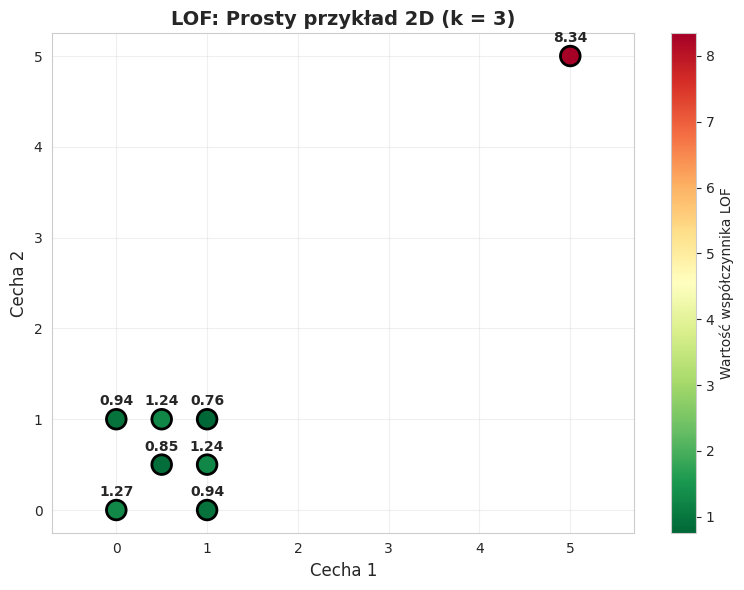

In [40]:
# Test 1: Prosty przykład 2D z jednym punktem odstającym (outlierem)
print("Test 1: LOF na prostych danych 2D")
print("=" * 50)

# Dane: skupisko punktów + jeden punkt odstający
X_cluster = np.array([
    [0, 0],
    [1, 1],
    [1, 0],
    [0, 1],
    [0.5, 0.5],
    [1, 0.5],
    [0.5, 1]
])
X_outlier = np.array([[5, 5]])
X = np.vstack([X_cluster, X_outlier])

# Dopasowanie modelu LOF
lof = LOF(n_neighbors=3)
scores = lof.fit_predict(X)

print(f"Liczba próbek: {X.shape[0]}, liczba cech: {X.shape[1]}")
print(f"\nWyniki LOF:")
for i, score in enumerate(scores):
    etykieta = "ODSTAJĄCY" if score > 1.5 else "NORMALNY"
    print(f"  Punkt {i}: LOF = {score:.3f} [{etykieta}]")

# Wizualizacja
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Punkty zabarwione wg wartości LOF
scatter = ax.scatter(
    X[:, 0], X[:, 1],
    c=scores, s=200,
    cmap='RdYlGn_r',
    edgecolors='black',
    linewidths=2
)

# Adnotacje z wartościami LOF
for i, (x, y) in enumerate(X):
    ax.annotate(
        f'{scores[i]:.2f}',
        (x, y),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center',
        fontsize=10,
        fontweight='bold'
    )

ax.set_xlabel('Cecha 1', fontsize=12)
ax.set_ylabel('Cecha 2', fontsize=12)
ax.set_title('LOF: Prosty przykład 2D (k = 3)', fontsize=14, fontweight='bold')

# Pasek kolorów
plt.colorbar(scatter, ax=ax, label='Wartość współczynnika LOF')

ax.grid(True, alpha=0.3)
ax.axis('equal')
plt.tight_layout()
plt.savefig('../benchmarks/results/raport2/raport2_lof_simple.png', dpi=300, bbox_inches='tight')
print("Zapisano: benchmarks/results/raport2/raport2_lof_simple.png")
plt.show()



Test 2: LOF na danych gaussowskich

Metryki (próg = 1.5):
  Precyzja (Precision): 0.667
  Czułość (Recall): 1.000
  Miara F1: 0.800
Zapisano: benchmarks/results/raport2/raport2_lof_gaussian.png


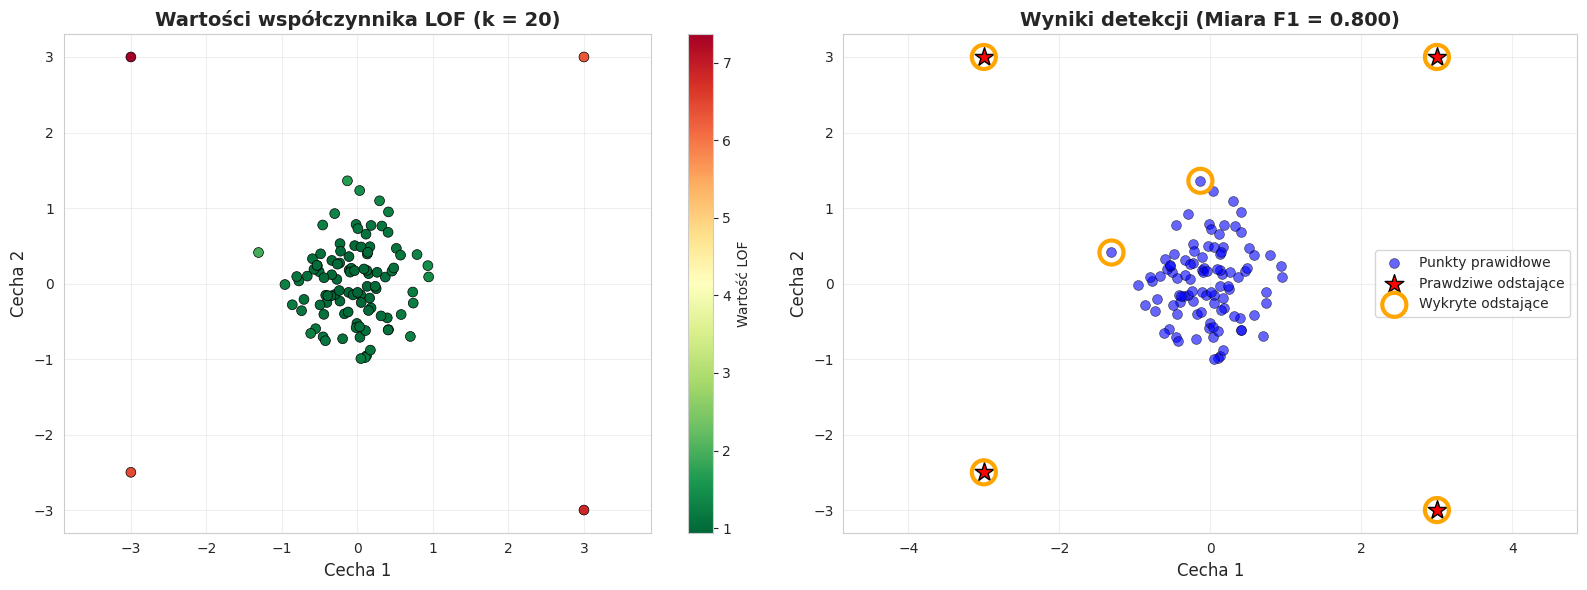

In [34]:
# Test 2: Gaussowskie klastry z punktami odstającymi
print("\nTest 2: LOF na danych gaussowskich")
print("=" * 50)

np.random.seed(42)

# Generowanie danych: skupisko gaussowskie (inliers)
X_inliers = np.random.randn(100, 2) * 0.5

# Dodanie punktów odstających
X_outliers = np.array([
    [3, 3],
    [-3, 3],
    [3, -3],
    [-3, -2.5]
])

X = np.vstack([X_inliers, X_outliers])
y_true = np.hstack([np.zeros(100), np.ones(4)])  # Etykiety rzeczywiste (0 = normalny, 1 = odstający)

# Dopasowanie modelu LOF
lof = LOF(n_neighbors=20)
scores = lof.fit_predict(X)

# Próg decyzyjny
threshold = 1.5
y_pred = (scores > threshold).astype(int)

# Obliczanie metryk
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"\nMetryki (próg = {threshold}):")
print(f"  Precyzja (Precision): {precision:.3f}")
print(f"  Czułość (Recall): {recall:.3f}")
print(f"  Miara F1: {f1:.3f}")

# Wizualizacja wyników
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Wykres 1: Wartości współczynnika LOF ---
scatter1 = axes[0].scatter(
    X[:, 0], X[:, 1],
    c=scores, s=50,
    cmap='RdYlGn_r',
    edgecolors='black',
    linewidths=0.5
)
axes[0].set_xlabel('Cecha 1', fontsize=12)
axes[0].set_ylabel('Cecha 2', fontsize=12)
axes[0].set_title('Wartości współczynnika LOF (k = 20)', fontsize=14, fontweight='bold')
plt.colorbar(scatter1, ax=axes[0], label='Wartość LOF')
axes[0].grid(True, alpha=0.3)
axes[0].axis('equal')

# --- Wykres 2: Wyniki detekcji w porównaniu z prawdą ---
axes[1].scatter(
    X[y_true == 0, 0], X[y_true == 0, 1],
    c='blue', s=50, alpha=0.6,
    label='Punkty prawidłowe',
    edgecolors='black', linewidths=0.5
)
axes[1].scatter(
    X[y_true == 1, 0], X[y_true == 1, 1],
    c='red', s=200, marker='*',
    label='Prawdziwe odstające',
    edgecolors='black', linewidths=1
)
axes[1].scatter(
    X[y_pred == 1, 0], X[y_pred == 1, 1],
    facecolors='none', s=300, marker='o',
    edgecolors='orange', linewidths=3,
    label='Wykryte odstające'
)
axes[1].set_xlabel('Cecha 1', fontsize=12)
axes[1].set_ylabel('Cecha 2', fontsize=12)
axes[1].set_title(f'Wyniki detekcji (Miara F1 = {f1:.3f})', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].axis('equal')

plt.tight_layout()
plt.savefig('../benchmarks/results/raport2/raport2_lof_gaussian.png', dpi=300, bbox_inches='tight')
print("Zapisano: benchmarks/results/raport2/raport2_lof_gaussian.png")
plt.show()


Test 3: Wpływ parametru k na wyniki LOF
Zapisano: benchmarks/results/raport2_lof_k_parameter.png


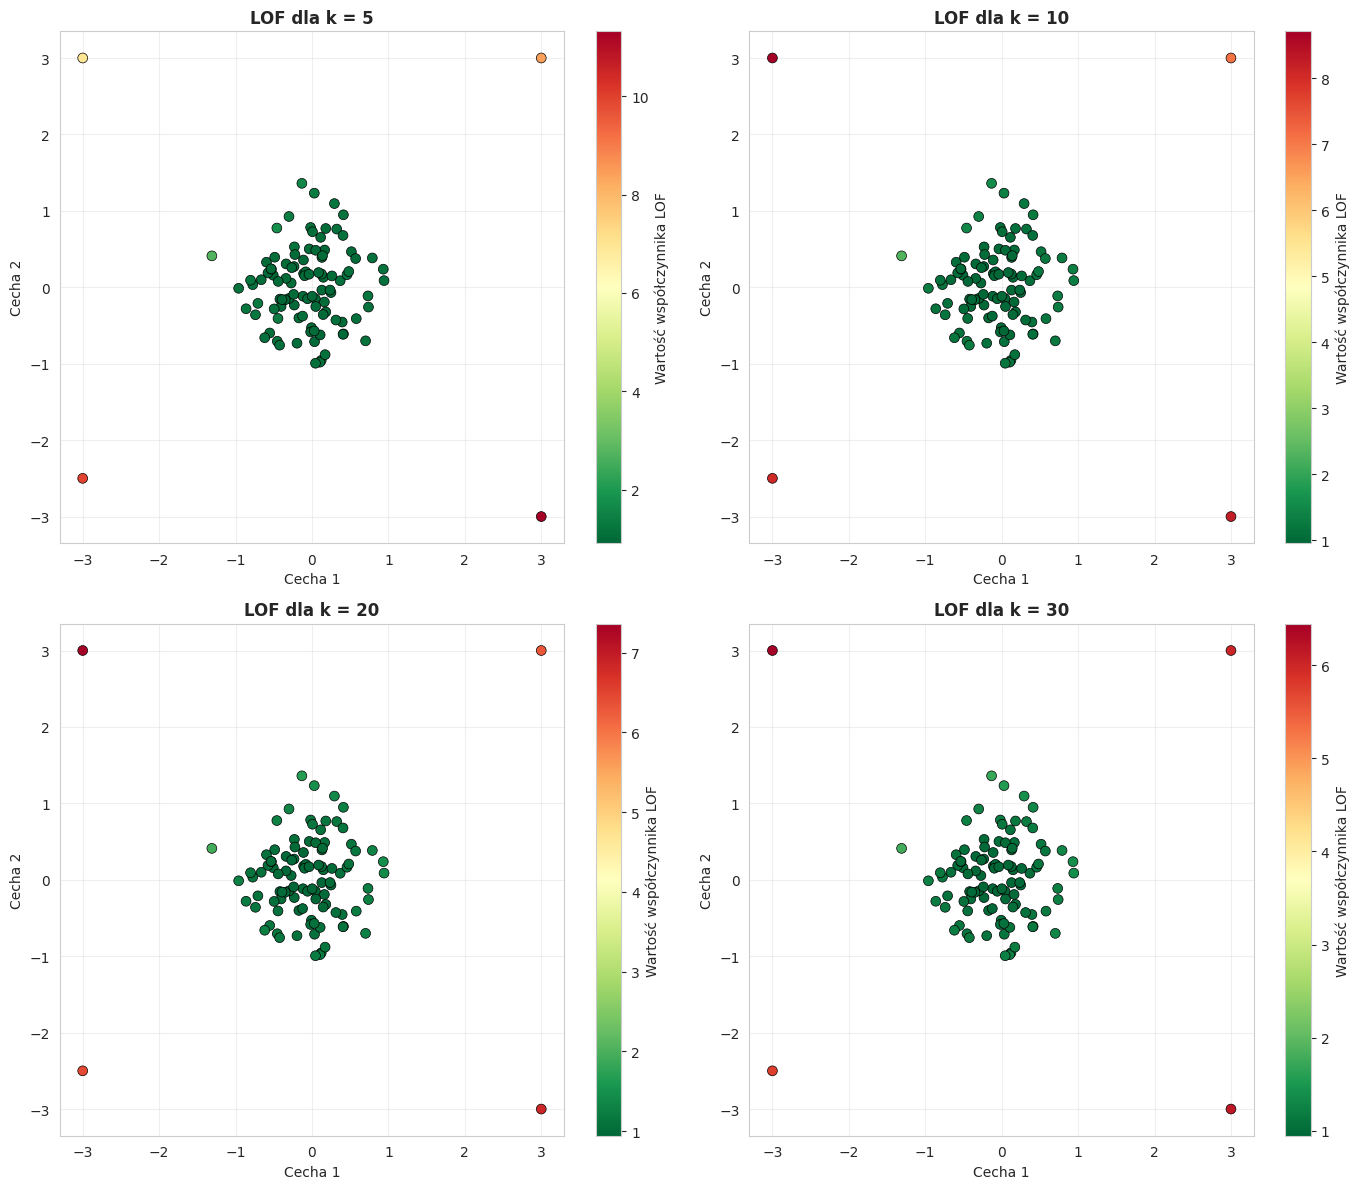


Obserwacje:
  - Małe wartości k: bardziej wrażliwe na anomalie lokalne (pojedyncze punkty w gęstych regionach)
  - Duże wartości k: wykrywają anomalie globalne (punkty odległe od całej populacji)


In [25]:
# Test 3: Wpływ parametru k na wyniki LOF
print("\nTest 3: Wpływ parametru k na wyniki LOF")
print("=" * 50)

k_values = [5, 10, 20, 30]
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, k in enumerate(k_values):
    lof = LOF(n_neighbors=k)
    scores = lof.fit_predict(X)
    
    scatter = axes[idx].scatter(
        X[:, 0], X[:, 1],
        c=scores, s=50,
        cmap='RdYlGn_r',
        edgecolors='black',
        linewidths=0.5
    )
    axes[idx].set_xlabel('Cecha 1', fontsize=10)
    axes[idx].set_ylabel('Cecha 2', fontsize=10)
    axes[idx].set_title(f'LOF dla k = {k}', fontsize=12, fontweight='bold')
    plt.colorbar(scatter, ax=axes[idx], label='Wartość współczynnika LOF')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].axis('equal')

plt.tight_layout()
plt.savefig('../benchmarks/results/raport2_lof_k_parameter.png', dpi=300, bbox_inches='tight')
print("Zapisano: benchmarks/results/raport2_lof_k_parameter.png")
plt.show()

print("\nObserwacje:")
print("  - Małe wartości k: bardziej wrażliwe na anomalie lokalne (pojedyncze punkty w gęstych regionach)")
print("  - Duże wartości k: wykrywają anomalie globalne (punkty odległe od całej populacji)")

## 2. Principal Component Analysis (PCA)

### 2.1 Algorytm

PCA redukuje wymiarowość danych poprzez projekcję na kierunki maksymalnej wariancji.

**Kroki algorytmu**:
1. Standaryzacja danych
2. Obliczenie macierzy kowariancji
3. Wyznaczenie wektorów własnych (składowych głównych)
4. Projekcja danych na PC

**Detekcja anomalii**:
- **Reconstruction Error**: `||x - x_reconstructed||²`
- **Mahalanobis Distance**: odległość w przestrzeni PC z uwzględnieniem wariancji



Test 4: PCA – metoda błędu rekonstrukcji

Udział wyjaśnionej wariancji: 0.927
Średni błąd rekonstrukcji (punkty prawidłowe): 0.0642
Błędy rekonstrukcji (punkty odstające): [22.63484141 18.50751546]
Zapisano: benchmarks/resultsraport2//raport2_pca_reconstruction.png


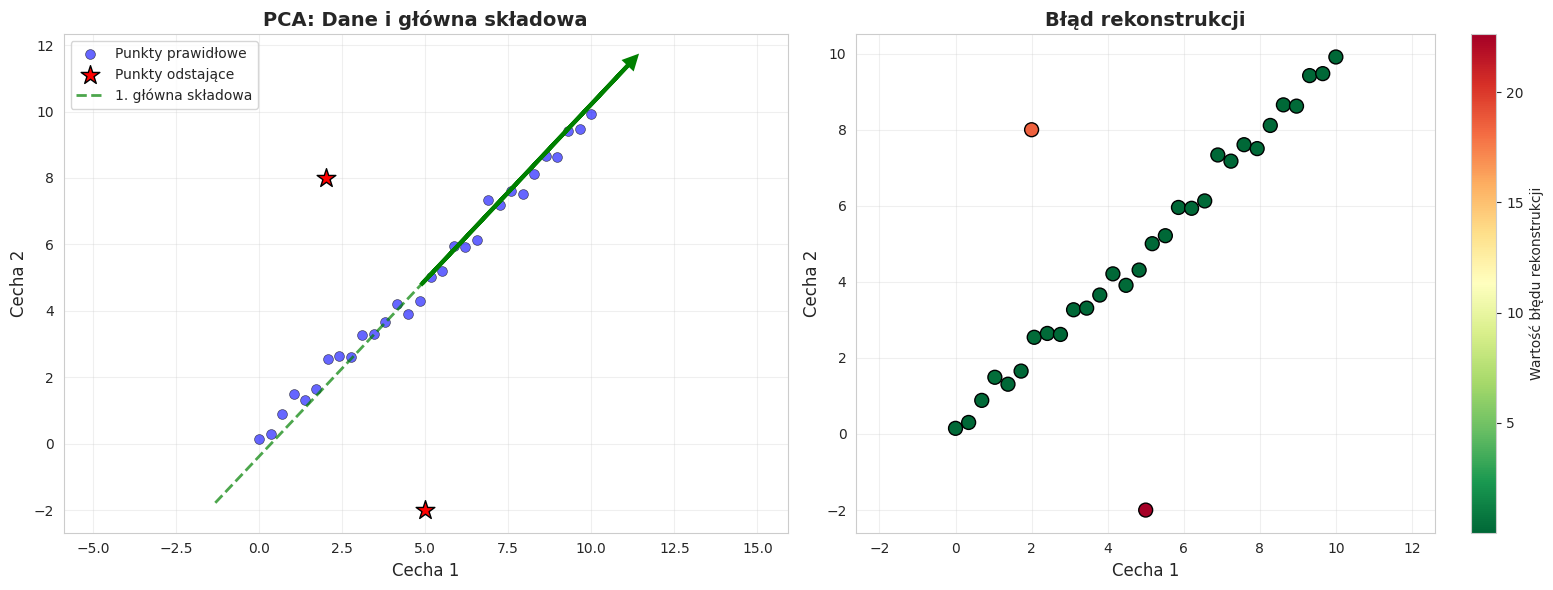

In [38]:
# Test 4: PCA – metoda błędu rekonstrukcji
print("\nTest 4: PCA – metoda błędu rekonstrukcji")
print("=" * 50)

# Dane: punkty wzdłuż głównej osi + punkty odstające prostopadłe
np.random.seed(42)
X_line = np.column_stack([
    np.linspace(0, 10, 30),
    np.linspace(0, 10, 30) + np.random.randn(30) * 0.3
])
X_outliers_pca = np.array([
    [5, -2],
    [2, 8]
])
X_pca = np.vstack([X_line, X_outliers_pca])

# Dopasowanie modelu PCA (1 składowa, metoda rekonstrukcji)
pca = PCAAnomaly(n_components=1, method='reconstruction')
pca.fit(X_pca)

# Obliczenie błędów rekonstrukcji
errors = pca.reconstruction_error(X_pca)
scores = pca.score_samples(X_pca)

print(f"\nUdział wyjaśnionej wariancji: {pca.explained_variance_ratio_[0]:.3f}")
print(f"Średni błąd rekonstrukcji (punkty prawidłowe): {np.mean(errors[:30]):.4f}")
print(f"Błędy rekonstrukcji (punkty odstające): {errors[30:]}")

# Wizualizacja wyników
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Wykres 1: Dane z kierunkiem głównej składowej ---
axes[0].scatter(
    X_pca[:30, 0], X_pca[:30, 1],
    c='blue', s=50, alpha=0.6,
    label='Punkty prawidłowe',
    edgecolors='black', linewidths=0.5
)
axes[0].scatter(
    X_pca[30:, 0], X_pca[30:, 1],
    c='red', s=200, marker='*',
    label='Punkty odstające',
    edgecolors='black', linewidths=1
)

# Główna składowa (pierwszy wektor własny)
mean = pca.mean_
pc = pca.components_[0] * pca.std_  # Odstandaryzowanie dla wizualizacji
axes[0].arrow(
    mean[0], mean[1],
    pc[0]*3, pc[1]*3,
    head_width=0.3, head_length=0.3,
    fc='green', ec='green', linewidth=3
)
axes[0].plot(
    [mean[0] - pc[0]*3, mean[0] + pc[0]*3],
    [mean[1] - pc[1]*3, mean[1] + pc[1]*3],
    'g--', linewidth=2,
    label='1. główna składowa',
    alpha=0.7
)

axes[0].set_xlabel('Cecha 1', fontsize=12)
axes[0].set_ylabel('Cecha 2', fontsize=12)
axes[0].set_title('PCA: Dane i główna składowa', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].axis('equal')

# --- Wykres 2: Błąd rekonstrukcji ---
scatter2 = axes[1].scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=errors, s=100,
    cmap='RdYlGn_r',
    edgecolors='black', linewidths=1
)
axes[1].set_xlabel('Cecha 1', fontsize=12)
axes[1].set_ylabel('Cecha 2', fontsize=12)
axes[1].set_title('Błąd rekonstrukcji', fontsize=14, fontweight='bold')
plt.colorbar(scatter2, ax=axes[1], label='Wartość błędu rekonstrukcji')
axes[1].grid(True, alpha=0.3)
axes[1].axis('equal')

plt.tight_layout()
plt.savefig('../benchmarks/results/raport2/raport2_pca_reconstruction.png', dpi=300, bbox_inches='tight')
print("Zapisano: benchmarks/resultsraport2//raport2_pca_reconstruction.png")
plt.show()


Test 5: PCA – analiza wariancji wyjaśnionej

Wariancja wyjaśniona przez poszczególne składowe:
  PC1: 0.3643 (36.43%)
  PC2: 0.2205 (22.05%)
  PC3: 0.2101 (21.01%)
  PC4: 0.1699 (16.99%)
  PC5: 0.0352 (3.52%)

Skumulowana wariancja wyjaśniona:
  Pierwsze 1 składowe: 0.3643 (36.43%)
  Pierwsze 2 składowe: 0.5848 (58.48%)
  Pierwsze 3 składowe: 0.7949 (79.49%)
  Pierwsze 4 składowe: 0.9648 (96.48%)
  Pierwsze 5 składowe: 1.0000 (100.00%)
Zapisano: benchmarks/results/raport2/raport2_pca_variance.png


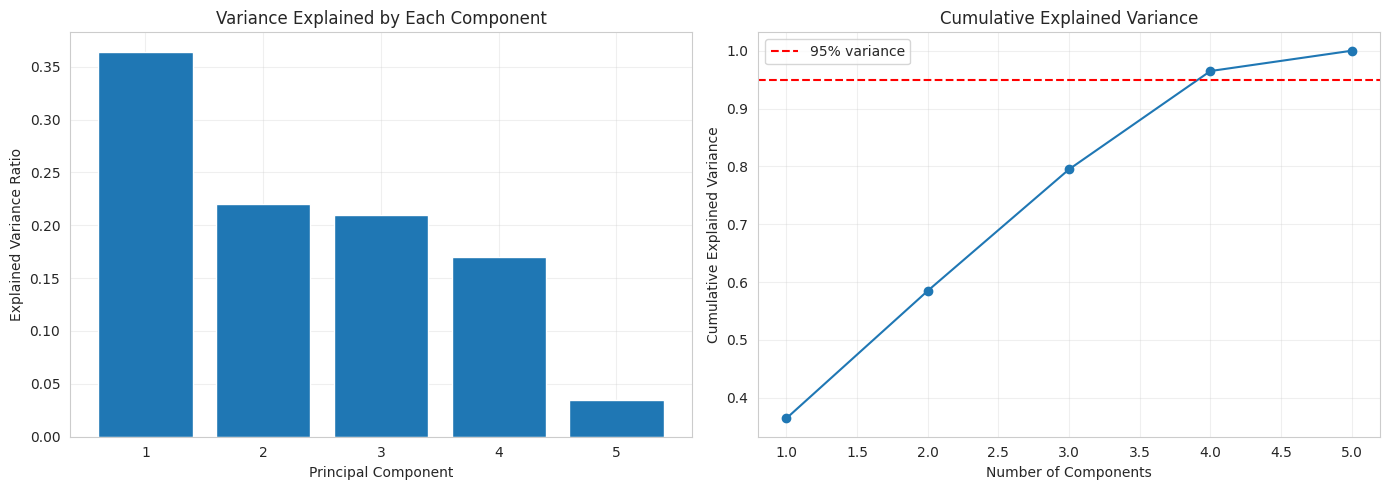

In [37]:
# Test 5: PCA – analiza wariancji wyjaśnionej
print("\nTest 5: PCA – analiza wariancji wyjaśnionej")
print("=" * 50)

# Generowanie danych 5-wymiarowych
np.random.seed(42)
n_samples = 200

# Tworzenie skorelowanych cech
z1 = np.random.randn(n_samples)
z2 = np.random.randn(n_samples)
z3 = np.random.randn(n_samples) * 0.1

X_5d = np.column_stack([
    z1 + z2 + np.random.randn(n_samples) * 0.1,   # silna korelacja
    z1 - z2 + np.random.randn(n_samples) * 0.1,   # silna korelacja
    z1 * 0.5 + np.random.randn(n_samples) * 0.3,  # umiarkowana korelacja
    z3,                                           # niska wariancja
    np.random.randn(n_samples) * 0.05             # bardzo niska wariancja
])

# Dopasowanie PCA ze wszystkimi składowymi
pca_all = PCAAnomaly(n_components=5)
pca_all.fit(X_5d)

print(f"\nWariancja wyjaśniona przez poszczególne składowe:")
for i, var in enumerate(pca_all.explained_variance_ratio_):
    print(f"  PC{i+1}: {var:.4f} ({var*100:.2f}%)")

cumsum = np.cumsum(pca_all.explained_variance_ratio_)
print(f"\nSkumulowana wariancja wyjaśniona:")
for i, var in enumerate(cumsum):
    print(f"  Pierwsze {i+1} składowe: {var:.4f} ({var*100:.2f}%)")

# Wizualizacja wariancji wyjaśnionej
fig = pca_all.plot_explained_variance()
plt.savefig('../benchmarks/results/raport2/raport2_pca_variance.png', dpi=300, bbox_inches='tight')
print("Zapisano: benchmarks/results/raport2/raport2_pca_variance.png")
plt.show()


Test 6: PCA – metoda odległości Mahalanobisa

Odległości Mahalanobisa:
  Średnia (punkty prawidłowe): 1.071
  Punkty odstające: [5.65446616 5.03096274]
  Próg decyzyjny: 2.164
  Liczba wykrytych punktów odstających: 6
Zapisano: benchmarks/results/raport2/raport2_pca_mahalanobis.png


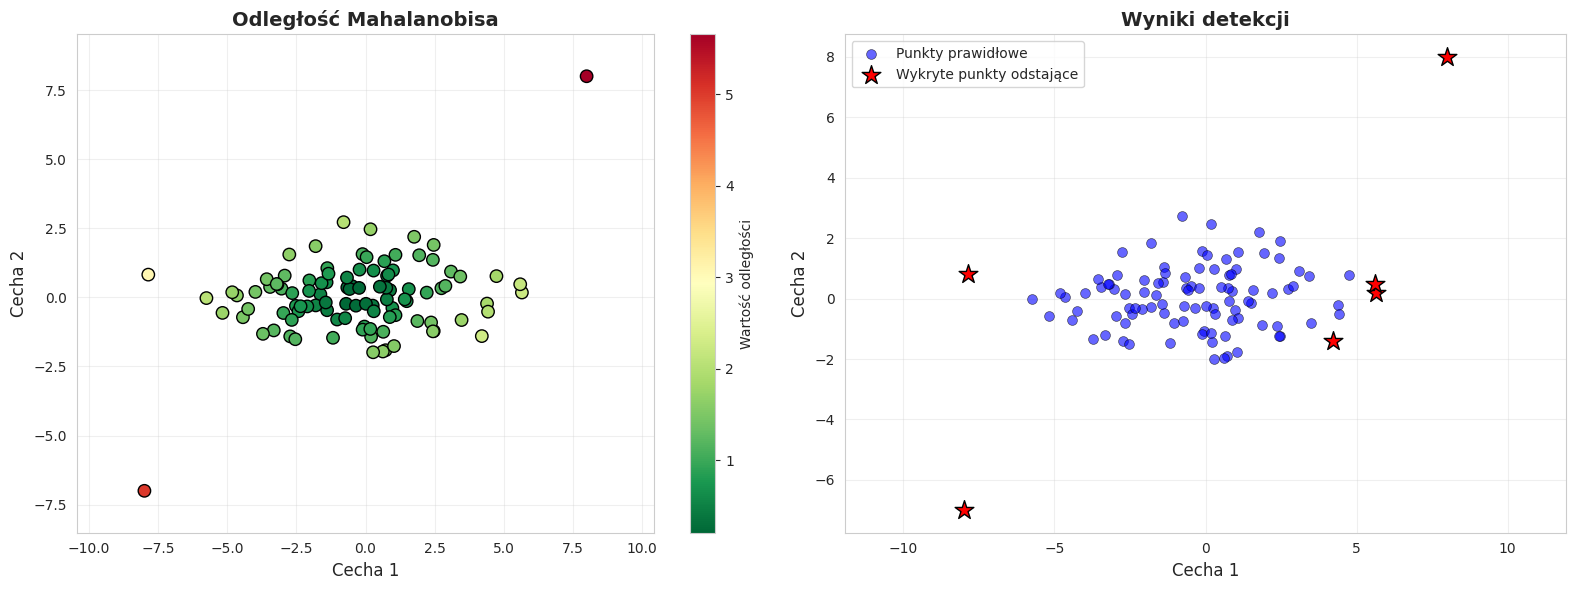

In [36]:
# Test 6: PCA – metoda odległości Mahalanobisa
print("\nTest 6: PCA – metoda odległości Mahalanobisa")
print("=" * 50)

# Generowanie danych: wydłużony klaster
np.random.seed(42)
X_elongated = np.random.randn(100, 2)
X_elongated[:, 0] *= 3  # rozciągnięcie wzdłuż osi X

# Dodanie punktów odstających
X_outliers_maha = np.array([[8, 8], [-8, -7]])
X_maha = np.vstack([X_elongated, X_outliers_maha])

# Dopasowanie PCA metodą Mahalanobisa
pca_maha = PCAAnomaly(n_components=2, method='mahalanobis', contamination=0.05)
pca_maha.fit(X_maha)

# Obliczenie odległości Mahalanobisa i etykiet
distances = pca_maha.mahalanobis_distance(X_maha)
labels = pca_maha.predict(X_maha)

print(f"\nOdległości Mahalanobisa:")
print(f"  Średnia (punkty prawidłowe): {np.mean(distances[:100]):.3f}")
print(f"  Punkty odstające: {distances[100:]}")
print(f"  Próg decyzyjny: {-pca_maha.threshold_:.3f}")
print(f"  Liczba wykrytych punktów odstających: {np.sum(labels)}")

# Wizualizacja wyników
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Wykres 1: Odległości Mahalanobisa ---
scatter1 = axes[0].scatter(
    X_maha[:, 0], X_maha[:, 1],
    c=distances, s=80,
    cmap='RdYlGn_r',
    edgecolors='black', linewidths=1
)
axes[0].set_xlabel('Cecha 1', fontsize=12)
axes[0].set_ylabel('Cecha 2', fontsize=12)
axes[0].set_title('Odległość Mahalanobisa', fontsize=14, fontweight='bold')
plt.colorbar(scatter1, ax=axes[0], label='Wartość odległości')
axes[0].grid(True, alpha=0.3)
axes[0].axis('equal')

# --- Wykres 2: Wyniki detekcji ---
axes[1].scatter(
    X_maha[labels == 0, 0], X_maha[labels == 0, 1],
    c='blue', s=50, alpha=0.6,
    label='Punkty prawidłowe',
    edgecolors='black', linewidths=0.5
)
axes[1].scatter(
    X_maha[labels == 1, 0], X_maha[labels == 1, 1],
    c='red', s=200, marker='*',
    label='Wykryte punkty odstające',
    edgecolors='black', linewidths=1
)
axes[1].set_xlabel('Cecha 1', fontsize=12)
axes[1].set_ylabel('Cecha 2', fontsize=12)
axes[1].set_title('Wyniki detekcji', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].axis('equal')

plt.tight_layout()
plt.savefig('../benchmarks/results/raport2/raport2_pca_mahalanobis.png', dpi=300, bbox_inches='tight')
print("Zapisano: benchmarks/results/raport2/raport2_pca_mahalanobis.png")
plt.show()

## 3. Porównanie LOF vs PCA

Sprawdzmy, jak obie metody radzą sobie z tym samym zbiorem danych.


Test 7: Porównanie metod LOF i PCA

Wyniki LOF:
  Precyzja (Precision): 0.357
  Czułość (Recall): 1.000
  Miara F1: 0.526

Wyniki PCA:
  Precyzja (Precision): 0.375
  Czułość (Recall): 0.600
  Miara F1: 0.462
Zapisano: benchmarks/results/raport2_comparison.png


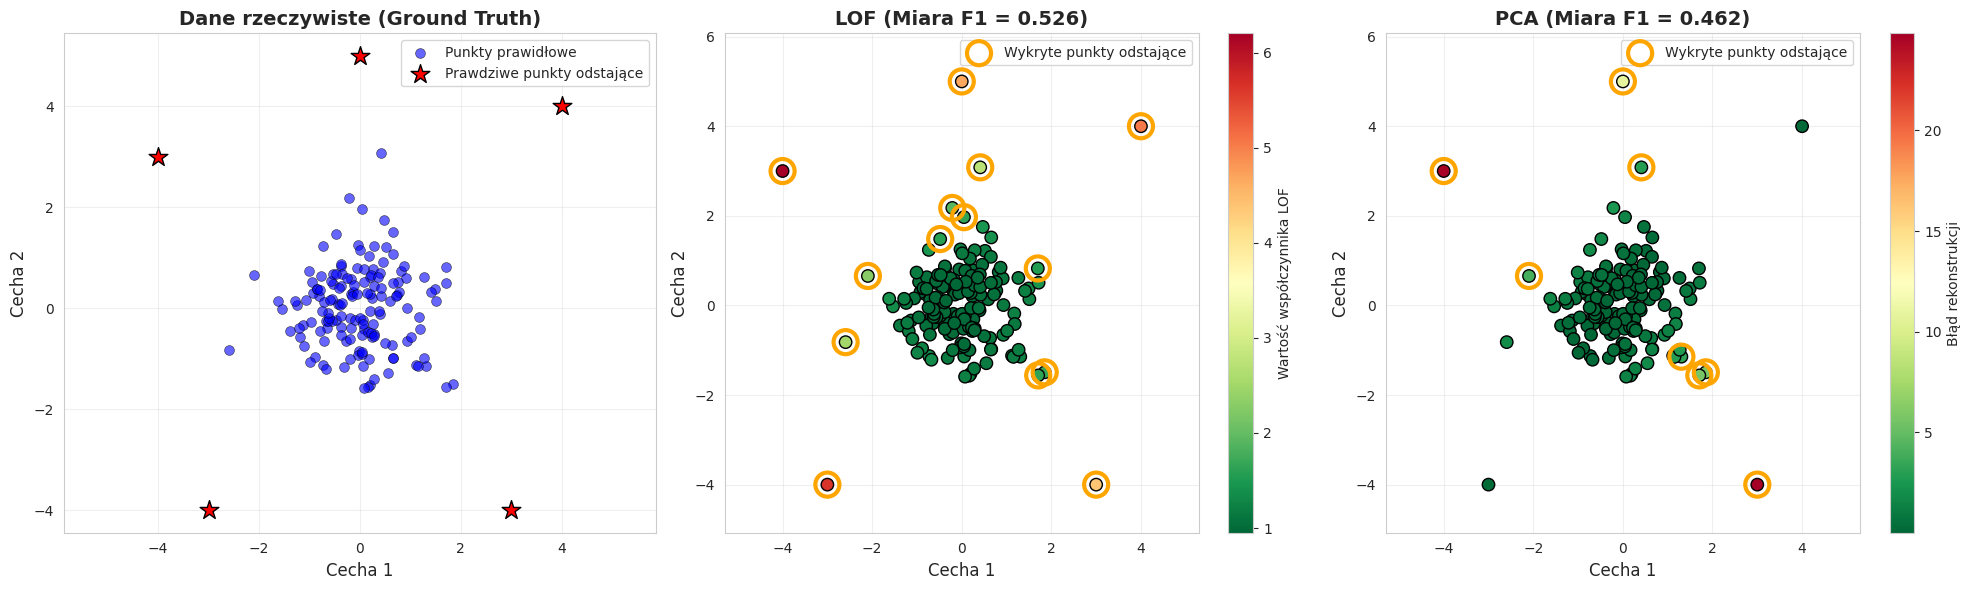

In [35]:
# Test 7: Porównanie metod LOF i PCA
print("\nTest 7: Porównanie metod LOF i PCA")
print("=" * 50)

# Generowanie danych testowych
np.random.seed(42)
X_test = np.random.randn(150, 2) * 0.8
X_test_outliers = np.array([
    [4, 4],
    [-4, 3],
    [3, -4],
    [-3, -4],
    [0, 5]
])
X_test_combined = np.vstack([X_test, X_test_outliers])
y_test_true = np.hstack([np.zeros(150), np.ones(5)])  # Etykiety rzeczywiste

# --- Metoda LOF ---
lof_comp = LOF(n_neighbors=15)
lof_scores = lof_comp.fit_predict(X_test_combined)
lof_labels = (lof_scores > 1.5).astype(int)

# --- Metoda PCA ---
pca_comp = PCAAnomaly(n_components=1, method='reconstruction', contamination=0.05)
pca_comp.fit(X_test_combined)
pca_errors = pca_comp.reconstruction_error(X_test_combined)
pca_labels = pca_comp.predict(X_test_combined)

# --- Obliczenie metryk ---
from sklearn.metrics import precision_score, recall_score, f1_score

lof_precision = precision_score(y_test_true, lof_labels, zero_division=0)
lof_recall = recall_score(y_test_true, lof_labels)
lof_f1 = f1_score(y_test_true, lof_labels)

pca_precision = precision_score(y_test_true, pca_labels, zero_division=0)
pca_recall = recall_score(y_test_true, pca_labels)
pca_f1 = f1_score(y_test_true, pca_labels)

print(f"\nWyniki LOF:")
print(f"  Precyzja (Precision): {lof_precision:.3f}")
print(f"  Czułość (Recall): {lof_recall:.3f}")
print(f"  Miara F1: {lof_f1:.3f}")

print(f"\nWyniki PCA:")
print(f"  Precyzja (Precision): {pca_precision:.3f}")
print(f"  Czułość (Recall): {pca_recall:.3f}")
print(f"  Miara F1: {pca_f1:.3f}")

# --- Wizualizacja wyników ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# --- Wykres 1: Dane rzeczywiste (Ground Truth) ---
axes[0].scatter(
    X_test_combined[y_test_true == 0, 0],
    X_test_combined[y_test_true == 0, 1],
    c='blue', s=50, alpha=0.6,
    label='Punkty prawidłowe',
    edgecolors='black', linewidths=0.5
)
axes[0].scatter(
    X_test_combined[y_test_true == 1, 0],
    X_test_combined[y_test_true == 1, 1],
    c='red', s=200, marker='*',
    label='Prawdziwe punkty odstające',
    edgecolors='black', linewidths=1
)
axes[0].set_xlabel('Cecha 1', fontsize=12)
axes[0].set_ylabel('Cecha 2', fontsize=12)
axes[0].set_title('Dane rzeczywiste (Ground Truth)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].axis('equal')

# --- Wykres 2: Wyniki LOF ---
scatter2 = axes[1].scatter(
    X_test_combined[:, 0], X_test_combined[:, 1],
    c=lof_scores, s=80,
    cmap='RdYlGn_r',
    edgecolors='black', linewidths=1
)
axes[1].scatter(
    X_test_combined[lof_labels == 1, 0],
    X_test_combined[lof_labels == 1, 1],
    facecolors='none', s=300, marker='o',
    edgecolors='orange', linewidths=3,
    label='Wykryte punkty odstające'
)
axes[1].set_xlabel('Cecha 1', fontsize=12)
axes[1].set_ylabel('Cecha 2', fontsize=12)
axes[1].set_title(f'LOF (Miara F1 = {lof_f1:.3f})', fontsize=14, fontweight='bold')
plt.colorbar(scatter2, ax=axes[1], label='Wartość współczynnika LOF')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].axis('equal')

# --- Wykres 3: Wyniki PCA ---
scatter3 = axes[2].scatter(
    X_test_combined[:, 0], X_test_combined[:, 1],
    c=pca_errors, s=80,
    cmap='RdYlGn_r',
    edgecolors='black', linewidths=1
)
axes[2].scatter(
    X_test_combined[pca_labels == 1, 0],
    X_test_combined[pca_labels == 1, 1],
    facecolors='none', s=300, marker='o',
    edgecolors='orange', linewidths=3,
    label='Wykryte punkty odstające'
)
axes[2].set_xlabel('Cecha 1', fontsize=12)
axes[2].set_ylabel('Cecha 2', fontsize=12)
axes[2].set_title(f'PCA (Miara F1 = {pca_f1:.3f})', fontsize=14, fontweight='bold')
plt.colorbar(scatter3, ax=axes[2], label='Błąd rekonstrukcji')
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)
axes[2].axis('equal')

plt.tight_layout()
plt.savefig('../benchmarks/results/raport2/raport2_comparison.png', dpi=300, bbox_inches='tight')
print("Zapisano: benchmarks/results/raport2_comparison.png")
plt.show()

## 4. Podsumowanie

### 4.1 LOF (Local Outlier Factor)

**Zalety**:
- Wykrywa anomalie lokalne
- Odporny na różne gęstości w zbiorze
- Nie wymaga założeń o rozkładzie danych

**Wady**:
- Wysoka złożoność obliczeniowa O(n²) lub O(n log n) z KD-Tree
- Wrażliwy na wybór parametru k
- Może mieć problemy z danymi wysokowymiarowymi

### 4.2 PCA (Principal Component Analysis)

**Zalety**:
- Redukcja wymiarowości
- Interpretowalna transformacja
- Skuteczna dla danych z liniowymi zależnościami
- Niższa złożoność: O(nd² + d³)

**Wady**:
- Zakłada liniowość
- Wrażliwa na skalę danych
- Może przeoczyć nieliniowe anomalie
- Może nie wykryć anomalii w kierunkach niskiej wariancji

### 4.3 Kiedy używać której metody?

**LOF**:
- Dane z różnymi gęstościami
- Anomalie lokalne
- Niewielkie zbiory danych (< 10k próbek)

**PCA**:
- Dane wysokowymiarowe wymagające redukcji
- Liniowe zależności między cechami
- Duże zbiory danych
- Anomalie w kierunkach głównych wariancji
